**Importing Libraries**

In [ ]:
!pip install transformers pandas numpy scikit-learn emoji


In [ ]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

**1-Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import emoji
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

**2-Loading the datasets from paths**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Defining paths to the dataset files
train_path = "/content/drive/My Drive/Colab Notebooks/amh/train.tsv"
dev_path = "/content/drive/My Drive/Colab Notebooks/amh/dev.tsv"
test_path = "/content/drive/My Drive/Colab Notebooks/amh/test.tsv"

Mounted at /content/drive


**3-Displaying the Data Info**

In [ ]:
# Reading the files
train_df = pd.read_csv(train_path, sep="\t")
dev_df = pd.read_csv(dev_path, sep="\t")
test_df = pd.read_csv(test_path, sep="\t")

# Displaying data info
print("Train data shape:", train_df.shape)
print("Dev data shape:", dev_df.shape)
print("Test data shape:", test_df.shape)
print("\nTrain data columns:", train_df.columns.tolist())
print("\nSample data:")
train_df.head()

Train data shape: (5984, 2)
Dev data shape: (1497, 2)
Test data shape: (1999, 2)

Train data columns: ['tweet', 'label']

Sample data:


,tweet,label
0,Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባ...,negative
1,ይሄው ነው አይደል የእውቀትሽ ጥግ....በሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ...,negative
2,ዘገበ ይባላል? ሌላ የሚባል ነገር ካለ አንተዉ ንገረን!,negative
3,?? ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ ፏ ሲል አይናችን ተጨፍኖ እንዳይወ...,negative
4,ዠልጥ?? ???? ገገማ,negative


**4-Checking and Visualizing the label distribution**


Label distribution in train set:
label
neutral     3104
negative    1548
positive    1332
Name: count, dtype: int64

Percentage distribution:
label
neutral     51.9%
negative    25.9%
positive    22.3%
Name: count, dtype: object


<ipython-input-8-da2aca955102>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index.astype(str), y=label_counts.values, palette="viridis")


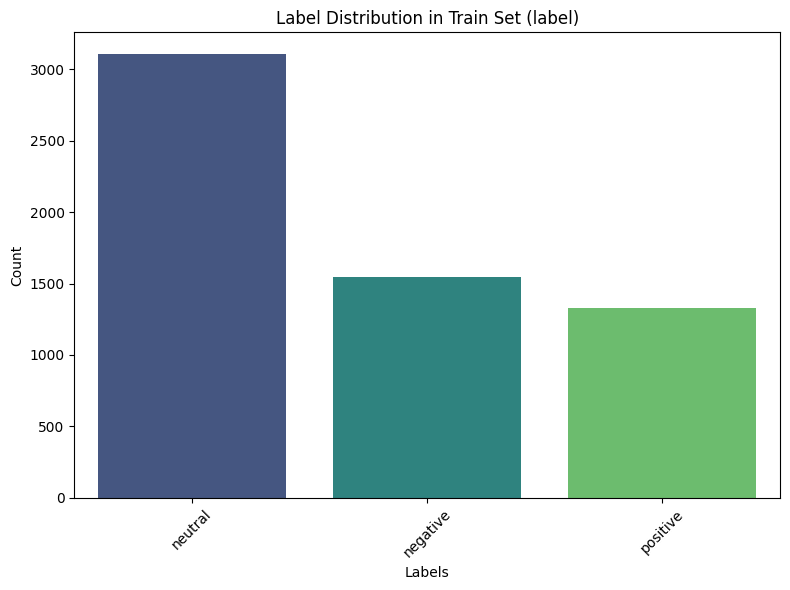

In [ ]:
# Checking the label distribution
print("\nLabel distribution in train set:")

if 'label' in train_df.columns:
    label_col = 'label'
    label_counts = train_df[label_col].value_counts()
    print(label_counts)
else:
    # loop detects label columns automatically
    for col in train_df.columns:
        if col != 'tweet':
            label_col = col
            label_counts = train_df[col].value_counts()
            print(f"Distribution of {col}:")
            print(label_counts)
            break
# Add percentage display
total = label_counts.sum()
percentages = (label_counts/total)*100
print("\nPercentage distribution:")
print(percentages.round(1).astype(str) + "%")


# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values, palette="viridis")

plt.title(f"Label Distribution in Train Set ({label_col})")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**5-Preprocessing function**

In [ ]:
# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase the text
    text = text.lower()
    # Remove @mentions
    text = re.sub(r'@\w+', '@user', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Replace emojis with text
    text = emoji.replace_emoji(text, replace='')
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Applying the preprocessing function
train_df['processed_text'] = train_df['tweet'].apply(preprocess_text)
dev_df['processed_text'] = dev_df['tweet'].apply(preprocess_text)
test_df['processed_text'] = test_df['tweet'].apply(preprocess_text)


**6-Label Preprocessing and Dataset Preparation**

In [ ]:

# Identify the label column
label_col = 'label' if 'label' in train_df.columns else None
if not label_col:
    for col in train_df.columns:
        if col not in ['tweet', 'processed_text', 'id']:
            label_col = col
            break

if label_col:
    # Get unique labels
    unique_labels = train_df[label_col].unique()
    print(f"Unique labels: {unique_labels}")

    # Create label mapping - modify if needed based on actual labels
    if len(unique_labels) == 3:
        if all(label in ['positive', 'negative', 'neutral'] for label in unique_labels):
            label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
        else:
            # Create a mapping based on found labels
            label_map = {label: i for i, label in enumerate(unique_labels)}

        print(f"Label mapping: {label_map}")

        # Convert labels to numeric
        train_df['label_id'] = train_df[label_col].map(label_map)
        dev_df['label_id'] = dev_df[label_col].map(label_map)
        test_df['label_id'] = test_df[label_col].map(label_map)

        # Check numeric label distribution
        print("\nNumeric label distribution:")
        print(train_df['label_id'].value_counts())
    else:
        print(f"Unexpected number of unique labels: {len(unique_labels)}")
        # If already numeric
        train_df['label_id'] = train_df[label_col].astype(int)
        dev_df['label_id'] = dev_df[label_col].astype(int)
        test_df['label_id'] = test_df[label_col].astype(int)

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)

# Verify column names
print("\nColumns in train_dataset:", train_dataset.column_names)
print("Sample from dataset:")
train_dataset[0]

Unique labels: ['negative' 'neutral' 'positive']
Label mapping: {'positive': 0, 'negative': 1, 'neutral': 2}

Numeric label distribution:
label_id
2    3104
1    1548
0    1332
Name: count, dtype: int64

Columns in train_dataset: ['tweet', 'label', 'processed_text', 'label_id']
Sample from dataset:


{'tweet': 'Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ',
 'label': 'negative',
 'processed_text': 'tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ',
 'label_id': 1}

**7-loading the Pretrained model**

In [ ]:
# Load AfriBERTa model and tokenizer
model_name = "Davlan/naija-twitter-sentiment-afriberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

**8-Tokenization**

In [ ]:
# Define tokenization function that processes text within the function
def tokenize_function(examples):
    # Use processed_text column if it exists, otherwise fall back to tweet
    texts = examples["processed_text"] if "processed_text" in examples else examples["tweet"]
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

# Apply tokenization
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_dev = dev_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Verify token ids
print("\nSample tokenized data:")
if len(tokenized_train) > 0:
    sample = tokenized_train[0]
    print(f"Input IDs: {sample['input_ids'][:10]}... (truncated)")
    print(f"Attention mask: {sample['attention_mask'][:10]}... (truncated)")


Map:   0%|          | 0/5984 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]


Sample tokenized data:
Input IDs: [0, 261, 7324, 923, 593, 24752, 507, 8410, 5079, 380]... (truncated)
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]... (truncated)


In [ ]:
# Manual approach to ensure correct label formatting
def prepare_dataset_with_labels(dataset):
    def convert_examples(examples):
        # Apply tokenization
        features = tokenizer(
            examples["processed_text"] if "processed_text" in examples else examples["tweet"],
            padding="max_length",
            truncation=True,
            max_length=128
        )

        # Add labels - ensure they're integers
        if "label_id" in examples:
            features["labels"] = [int(label) for label in examples["label_id"]]
        else:
            # Fall back to original label column
            features["labels"] = [int(label_map.get(label, 0)) for label in examples[label_col]]

        return features

    # Apply processing
    processed_dataset = dataset.map(convert_examples, batched=True)

    # Set format for PyTorch
    processed_dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"]
    )

    return processed_dataset

In [ ]:
# Process datasets ensuring correct label formatting
tokenized_train = prepare_dataset_with_labels(train_dataset)
tokenized_dev = prepare_dataset_with_labels(dev_dataset)
tokenized_test = prepare_dataset_with_labels(test_dataset)

# Verify labels are correctly formatted
print("\nVerifying label format:")
if len(tokenized_train) > 0:
    sample = tokenized_train[0]
    print(f"Labels type: {type(sample['labels'])}")
    print(f"Labels value: {sample['labels']}")

Map:   0%|          | 0/5984 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]


Verifying label format:
Labels type: <class 'torch.Tensor'>
Labels value: 1


**9-Loading and defining parameters**

In [ ]:
# Load model with proper number of classes (3 for sentiment)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,  # Set to True when ready to publish
    report_to="none"    # Disable Wandb reporting
)

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**10-Function for evaluation metrics**

In [ ]:

# Define metrics computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

**11-Training Model**

In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    compute_metrics=compute_metrics
)

# Train the model
print("\nStarting model training...")
trainer.train()


Starting model training...


model.safetensors:   0%|          | 0.00/503M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.906000,0.920848,0.580494,0.483700
2,0.671500,0.875242,0.597194,0.585170
3,0.509800,1.106978,0.574482,0.574344
4,0.292400,1.592143,0.562458,0.562228
5,0.178900,1.877893,0.568470,0.566341


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:397: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:397: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

TrainOutput(global_step=1870, training_loss=0.5376479235562411, metrics={'train_runtime': 642.8258, 'train_samples_per_second': 46.544, 'train_steps_per_second': 2.909, 'total_flos': 1642350180556800.0, 'train_loss': 0.5376479235562411, 'epoch': 5.0})

In [ ]:
# Evaluate on development set
print("\nEvaluating on development set...")
eval_results = trainer.evaluate(eval_dataset=tokenized_dev)
print(f"Dev Accuracy: {eval_results.get('eval_accuracy', 'N/A'):.4f}")
print(f"Dev F1 Score: {eval_results.get('eval_f1', 'N/A'):.4f}")



Evaluating on development set...


Dev Accuracy: 0.5972
Dev F1 Score: 0.5852


In [ ]:

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.predict(tokenized_test)

# Get predicted labels
test_preds = np.argmax(test_results.predictions, axis=1)

# Get true labels
test_labels = tokenized_test["labels"]
test_labels = test_labels.cpu().numpy() if hasattr(test_labels, "cpu") else test_labels

# Compute accuracy and F1 score
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average="weighted")

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Optional: map label IDs to label names if you have a label_map
inv_label_map = {v: k for k, v in label_map.items()}
actual_labels = [inv_label_map[label] for label in test_labels]
predicted_labels = [inv_label_map[pred] for pred in test_preds]

# Show a few predictions vs. actual
print("\nSample Actual vs Predicted:")
for i in range(10):
    print(f"Text: {test_df.iloc[i]['tweet']}")
    print(f"Actual: {actual_labels[i]} | Predicted: {predicted_labels[i]}")
    print("-" * 50)



Evaluating on test set...



Test Accuracy: 0.4312
Test F1 Score: 0.4926

Sample Actual vs Predicted:
Text: '@user ክብር እና ምስጋና ለዓለማት ፈጣሪ ይሁን'
Actual: positive | Predicted: positive
--------------------------------------------------
Text: 'ከህወሓት ጋር ድርድር ማለት ኢትዮጲያን ማፍረስ ዕቁብ መጣል ነው። #Nomore'
Actual: negative | Predicted: neutral
--------------------------------------------------
Text: 'እግዚአብሔር የተመሰገነ ይሁን ኢትዮጵያ አሸነፈች ። እንኳን ደስአለኝ ።'
Actual: positive | Predicted: positive
--------------------------------------------------
Text: 'ይህንን ካዩ እባክዎን ከእኔ ጋር ሶስት ያድርጉ'
Actual: neutral | Predicted: neutral
--------------------------------------------------
Text: '@user ሲሆን ሲሆን ወንድ ትወልጅያለሽ ሳይሆ ሳይሆን ሴት ትወልጃለሽ አለ መለስ . What a stupid analysis . And posted it here . ጅልነትህ ገደብ'
Actual: negative | Predicted: neutral
--------------------------------------------------
Text: 'አንቺ ቆንጆ ነሽ ፣ ባባ ነኝ እንደምነሽ ከየት መጣሽ አንቺ ፣ እንዴ እንዴ ወይኔ ውይ ሆንሽለት አንቺ ቆንጆ ነሽ ፣ ባባ ነኝ እንደምነሽ ከየት መጣሽ አንቺ ፣ እንዴ እንዴ ወይኔ ውይ'
Actual: positive | Predicted: neutral
----------

In [ ]:

# Print classification report
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds))



Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.47      0.59       438
           1       0.93      0.34      0.50      1337
           2       0.16      0.88      0.27       224

    accuracy                           0.43      1999
   macro avg       0.62      0.57      0.45      1999
weighted avg       0.81      0.43      0.49      1999



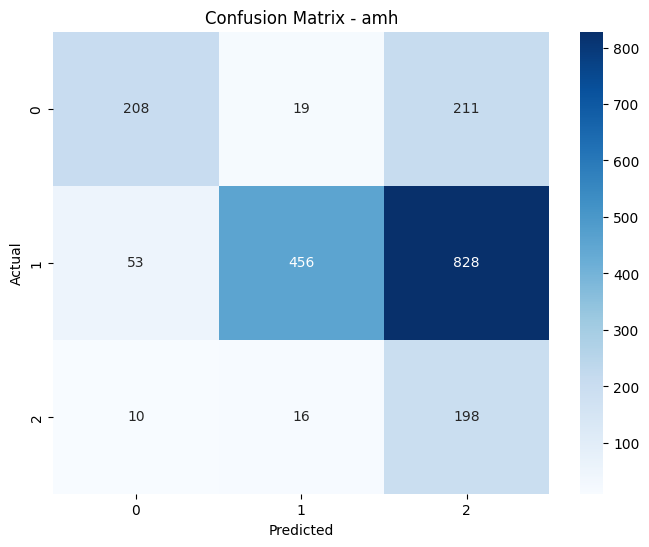

In [ ]:

# Get true labels and predicted labels
test_labels = tokenized_test["labels"].cpu().numpy()
test_preds = np.argmax(test_results.predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Infer language name from path
language_name = train_path.split("/")[-2]  # Igbo, Hausa, etc.

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {language_name}')
plt.show()


In [ ]:
# Save model
model_path = "./igbo-sentiment-afriberta"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"\nModel saved to {model_path}")


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:397: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(



Model saved to ./igbo-sentiment-afriberta


**Part II-Using Synthetic data**

In [ ]:
import random
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

# Function for synonym replacement
def synonym_replacement(text):
    words = text.split()
    new_words = []
    for word in words:
        # Get synonyms from WordNet
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Pick a random synonym
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:
                new_words.append(synonym)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Function to add random noise
def add_noise(text, noise_level=0.1):
    words = text.split()
    num_noise = int(len(words) * noise_level)
    for _ in range(num_noise):
        index = random.randint(0, len(words) - 1)
        words[index] = ''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=random.randint(3, 6)))
    return ' '.join(words)

# Augment the training data
augmented_train_df = train_df.copy()

# Apply synonym replacement and random noise
augmented_train_df['augmented_text'] = augmented_train_df['tweet'].apply(lambda x: synonym_replacement(x))
augmented_train_df['augmented_text'] = augmented_train_df['augmented_text'].apply(lambda x: add_noise(x))

# Assuming augmented_train_df contains your augmented data
augmented_train_df = pd.concat([augmented_train_df, augmented_train_df[['augmented_text', 'label']]], ignore_index=True)
augmented_train_df.head()

,tweet,label,processed_text,label_id,augmented_text
0,Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባ...,negative,tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባ...,1.0,Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ x...
1,ይሄው ነው አይደል የእውቀትሽ ጥግ....በሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ...,negative,ይሄው ነው አይደል የእውቀትሽ ጥግ....በሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ...,1.0,ይሄው ነው አይደል የእውቀትሽ rfl ሰሚ ከምትናገሪ ለምን ታሪክ አታነቢም...
2,ዘገበ ይባላል? ሌላ የሚባል ነገር ካለ አንተዉ ንገረን!,negative,ዘገበ ይባላል? ሌላ የሚባል ነገር ካለ አንተዉ ንገረን!,1.0,ዘገበ ይባላል? ሌላ የሚባል ነገር ካለ አንተዉ ንገረን!
3,?? ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ ፏ ሲል አይናችን ተጨፍኖ እንዳይወ...,negative,?? ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ ፏ ሲል አይናችን ተጨፍኖ እንዳይወ...,1.0,?? ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ crozj ሲል አይናችን ተጨፍኖ እ...
4,ዠልጥ?? ???? ገገማ,negative,ዠልጥ?? ???? ገገማ,1.0,ዠልጥ?? ???? ገገማ


**Applying same preprocessing function**

In [ ]:
# Preprocess the synthetic data text (augmented_text)
augmented_train_df['processed_text'] = augmented_train_df['augmented_text'].apply(preprocess_text)

# Map labels to IDs for the augmented data
augmented_train_df['label_id'] = augmented_train_df['label'].map(label_map)

# Convert to HuggingFace datasets
augmented_train_dataset = Dataset.from_pandas(augmented_train_df)

# Apply tokenization (same as before)
tokenized_augmented_train = augmented_train_dataset.map(tokenize_function, batched=True)

# Prepare the dataset with labels
tokenized_augmented_train = prepare_dataset_with_labels(tokenized_augmented_train)


Map:   0%|          | 0/11968 [00:00<?, ? examples/s]

Map:   0%|          | 0/11968 [00:00<?, ? examples/s]

**Retraining the model with augmented data**

In [ ]:
from datasets import concatenate_datasets

# Combine original and augmented datasets
combined_train_dataset = concatenate_datasets([tokenized_train, tokenized_augmented_train])

# Initialize trainer with the new combined dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_train_dataset,
    eval_dataset=tokenized_dev,
    compute_metrics=compute_metrics
)

# Now, you can continue with training
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.169600,2.133131,0.554442,0.557862
2,0.104300,3.203209,0.556446,0.557065
3,0.025300,3.571516,0.583166,0.573576
4,0.022600,3.726173,0.575818,0.572951
5,0.001600,3.858415,0.581830,0.578814


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:397: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:397: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

TrainOutput(global_step=5610, training_loss=0.11435882099596999, metrics={'train_runtime': 1755.7097, 'train_samples_per_second': 51.125, 'train_steps_per_second': 3.195, 'total_flos': 4927050541670400.0, 'train_loss': 0.11435882099596999, 'epoch': 5.0})

**Evaluating on training set**

In [ ]:
# Evaluate on development set
print("\nEvaluating on development set after retraining...")
eval_results = trainer.evaluate(eval_dataset=tokenized_dev)
print(f"Dev Accuracy: {eval_results.get('eval_accuracy', 'N/A'):.4f}")
print(f"Dev F1 Score: {eval_results.get('eval_f1', 'N/A'):.4f}")

# Evaluate on test set
print("\nEvaluating on test set after retraining...")
test_results = trainer.predict(tokenized_test)
test_preds = np.argmax(test_results.predictions, axis=1)

# Show a few sample predictions
print("\nSample Predictions:", test_preds[:10])

# Show prediction distribution
print("\nPrediction Distribution:")
print(pd.Series(test_preds).value_counts().sort_index())



Evaluating on development set after retraining...


Dev Accuracy: 0.5818
Dev F1 Score: 0.5788

Evaluating on test set after retraining...

Sample Predictions: [0 1 0 2 2 2 1 2 1 2]

Prediction Distribution:
0     271
1     706
2    1022
Name: count, dtype: int64



Classification Report:
              precision    recall  f1-score   support

    positive       0.75      0.46      0.57       438
    negative       0.89      0.47      0.62      1337
     neutral       0.18      0.81      0.29       224

    accuracy                           0.51      1999
   macro avg       0.61      0.58      0.49      1999
weighted avg       0.78      0.51      0.57      1999



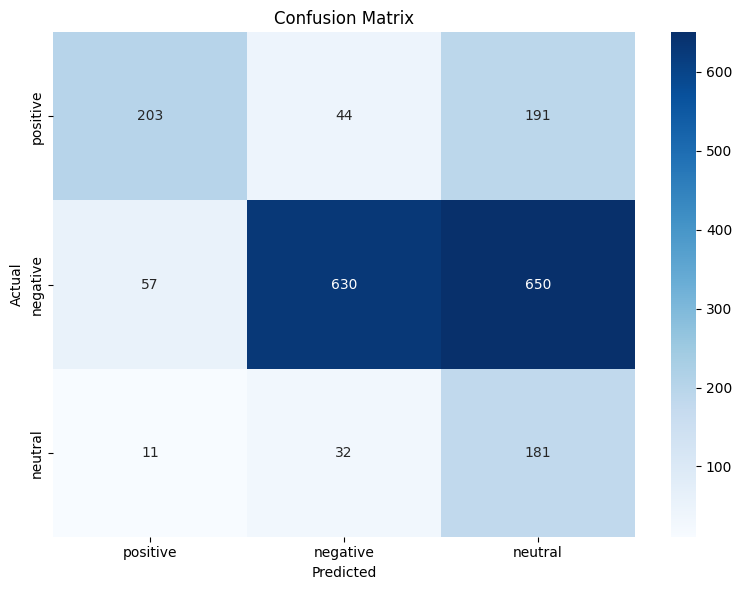


Sample Actual vs Predicted:
Text: '@user ክብር እና ምስጋና ለዓለማት ፈጣሪ ይሁን'
Actual: positive | Predicted: positive
--------------------------------------------------
Text: 'ከህወሓት ጋር ድርድር ማለት ኢትዮጲያን ማፍረስ ዕቁብ መጣል ነው። #Nomore'
Actual: negative | Predicted: negative
--------------------------------------------------
Text: 'እግዚአብሔር የተመሰገነ ይሁን ኢትዮጵያ አሸነፈች ። እንኳን ደስአለኝ ።'
Actual: positive | Predicted: positive
--------------------------------------------------
Text: 'ይህንን ካዩ እባክዎን ከእኔ ጋር ሶስት ያድርጉ'
Actual: neutral | Predicted: neutral
--------------------------------------------------
Text: '@user ሲሆን ሲሆን ወንድ ትወልጅያለሽ ሳይሆ ሳይሆን ሴት ትወልጃለሽ አለ መለስ . What a stupid analysis . And posted it here . ጅልነትህ ገደብ'
Actual: negative | Predicted: neutral
--------------------------------------------------
Text: 'አንቺ ቆንጆ ነሽ ፣ ባባ ነኝ እንደምነሽ ከየት መጣሽ አንቺ ፣ እንዴ እንዴ ወይኔ ውይ ሆንሽለት አንቺ ቆንጆ ነሽ ፣ ባባ ነኝ እንደምነሽ ከየት መጣሽ አንቺ ፣ እንዴ እንዴ ወይኔ ውይ'
Actual: positive | Predicted: neutral
--------------------------------------------------
Tex

In [ ]:
# === Classification Report ===
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=list(label_map.keys())))

# === Confusion Matrix ===
conf_mat = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Sample Predictions vs Actual ===
inv_label_map = {v: k for k, v in label_map.items()}
actual_labels = [inv_label_map[label] for label in test_labels]
predicted_labels = [inv_label_map[pred] for pred in test_preds]

print("\nSample Actual vs Predicted:")
for i in range(10):
    print(f"Text: {test_df.iloc[i]['tweet']}")
    print(f"Actual: {actual_labels[i]} | Predicted: {predicted_labels[i]}")
    print("-" * 50)


In [ ]:
# Save retrained model
model.save_pretrained("./retrained_amh-sentiment-afriberta")
tokenizer.save_pretrained("./retrained_amh-sentiment-afriberta")
print("\nRetrained model saved to './retrained_amh-sentiment-afriberta'")



Retrained model saved to './retrained_amh-sentiment-afriberta'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install huggingface_hub

In [ ]:
from google.colab import files

# 1. Compress your model folder
!zip -r retrained_amh-sentiment-afriberta.zip retrained_amh-sentiment-afriberta/

# 2. Download directly to your computer
files.download("retrained_amh-sentiment-afriberta.zip")

  adding: retrained_amh-sentiment-afriberta/ (stored 0%)
  adding: retrained_amh-sentiment-afriberta/tokenizer_config.json (deflated 75%)
  adding: retrained_amh-sentiment-afriberta/model.safetensors (deflated 7%)
  adding: retrained_amh-sentiment-afriberta/sentencepiece.bpe.model (deflated 51%)
  adding: retrained_amh-sentiment-afriberta/special_tokens_map.json (deflated 86%)
  adding: retrained_amh-sentiment-afriberta/config.json (deflated 54%)
  adding: retrained_amh-sentiment-afriberta/tokenizer.json (deflated 77%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>